### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

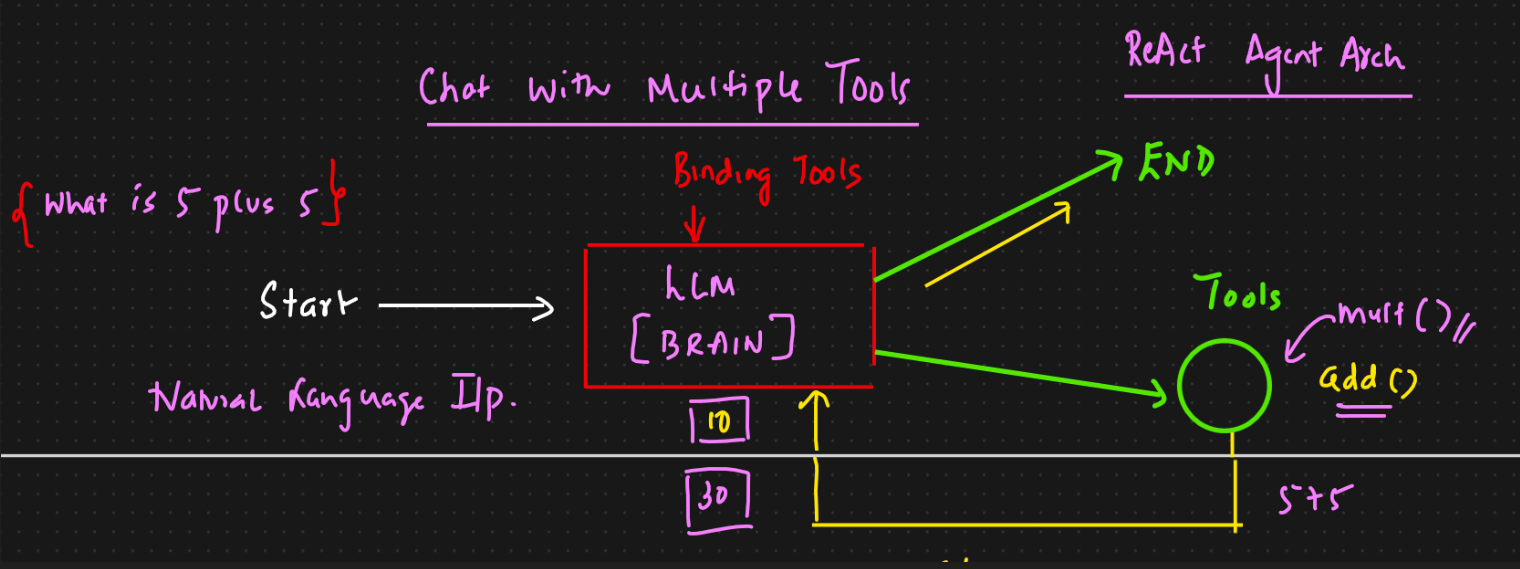

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

/Users/binod.kafle/Documents/personal/learning/agentic_ai/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention iss all you need")

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [5]:
wiki.invoke("What is machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"

In [7]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [8]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

/var/folders/_m/nv9cbmbs6h38d0yjvxbgmhpj_vx45m/T/ipykernel_68343/1283541007.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [9]:
tavily.invoke("Provide me the recent AI news for december 3rd 2025")

[{'title': 'AI News for Dec 3, 2025',
  'url': 'https://theautomateddaily.com/e/ai-news-for-dec-3-2025/',
  'content': 'Welcome to ’The Automated Daily’, your ultimate source for a streamlined and insightful daily news experience. Powered by cutting-edge Generative AI technology, we bring you the most crucial headlines of the day, carefully selected and delivered directly to your ears. Our intelligent algorithms scour the news landscape to sift through the noise, ensuring that you receive only the most relevant and significant stories. Join us as we condense the day’s news into a concise and captivating format, [...] keeping you informed and empowered. [...] -NVIDIA opens physical and digital AI\n  \n-Runway Gen‑4.5 video model\n  \n-Ecosia’s greener AI search\n  \n-Black Forest Labs raises $300M\n  \n-OpenAI invests in Thrive roll‑up\n  \n-a16z threads on strategy\n  \n  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n-  \n  \n  \n

In [17]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily,add,divide,multiply]

In [18]:
## Initialize my LLM model

from langchain_groq import ChatGroq

llm=ChatGroq(model="openai/gpt-oss-120b")

llm_with_tools=llm.bind_tools(tools)

In [19]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'The user asks: "What is the recent AI News". They likely want a summary of recent AI news. Need up-to-date info. We can use search tool. Use tavily_search_results_json with query "recent AI news".', 'tool_calls': [{'id': 'fc_b6c55db5-baab-4dde-ac3b-52487666eb87', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 81, 'prompt_tokens': 378, 'total_tokens': 459, 'completion_time': 0.169513724, 'prompt_time': 0.017134656, 'queue_time': 0.050419643, 'total_time': 0.18664838, 'completion_tokens_details': {'reasoning_tokens': 48}}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e88ce9c728', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--7417dd1a-f5f5-48ea-8095-f288b5cdb491-0', tool_calls=[{'name': 'tavily_search_results_json'

In [12]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'arxiv',
  'args': {'query': 'artificial intelligence 2025'},
  'id': 'fc_7bc6c92e-f293-4667-a7a0-e5bce0e859b7',
  'type': 'tool_call'}]

In [13]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

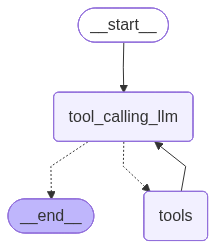

In [20]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [21]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for december 3rd 2025,add 4324 plus 35425 and then multiply by 3242")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for december 3rd 2025,add 4324 plus 35425 and then multiply by 3242
================================== Ai Message ==================================
Tool Calls:
  add (fc_4fa671e5-e0fe-4704-91e9-16a63f2abc18)
 Call ID: fc_4fa671e5-e0fe-4704-91e9-16a63f2abc18
  Args:
    a: 4324
    b: 35425
================================= Tool Message =================================
Name: add

39749
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_4edee624-ad40-441d-b31d-12e2edb3ec65)
 Call ID: fc_4edee624-ad40-441d-b31d-12e2edb3ec65
  Args:
    a: 39749
    b: 3242
================================= Tool Message =================================
Name: multiply

128866258
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_4b67c447-2b13-4fc7-b57c-4f015

### Agent Memory
#### Aim
Lets introduce Agent With Memory

In [23]:
messages=graph.invoke({"messages":HumanMessage(content="What is 34242 plus 34243")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 34242 plus 34243
================================== Ai Message ==================================

34242 + 34243 = **68 485**.


In [24]:
messages=[HumanMessage(content="Divide that by 5")]
messages=graph.invoke({"messages":messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide that by 5
================================== Ai Message ==================================

I’m not sure which value you’d like to divide by 5. Could you let me know the number (or result) you’d like to have divided?


#### MemorySaver
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

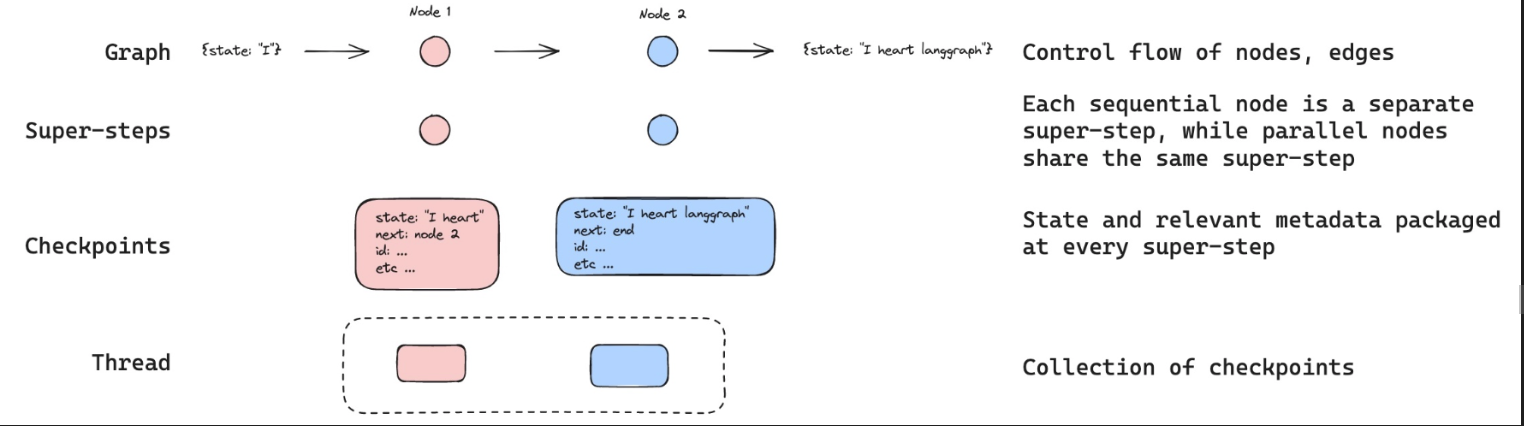

In [25]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

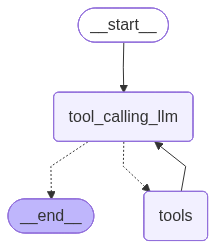

In [26]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_memory = builder.compile(checkpointer=memory)

# View
display(Image(graph_memory.get_graph().draw_mermaid_png()))

In [27]:
## Specify the thread

config={"configurable":{"thread_id":"1"}}
# Specify an input
messages = [HumanMessage(content="Add 12 and 13.")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (fc_5b1da990-9c13-46b3-b015-f2ca8ba2848d)
 Call ID: fc_5b1da990-9c13-46b3-b015-f2ca8ba2848d
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.


In [28]:
messages = [HumanMessage(content="add that number to 25")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (fc_5b1da990-9c13-46b3-b015-f2ca8ba2848d)
 Call ID: fc_5b1da990-9c13-46b3-b015-f2ca8ba2848d
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (fc_84d6ddc0-de2c-4343-b3e4-6eaf774a9b91)
 Call ID: fc_84d6ddc0-de2c-4343-b3e4-6eaf774a9b91
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ===========

In [29]:
messages = [HumanMessage(content="then multiply that number by 2")]
messages=graph_memory.invoke({"messages":messages},config=config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 12 and 13.
================================== Ai Message ==================================
Tool Calls:
  add (fc_5b1da990-9c13-46b3-b015-f2ca8ba2848d)
 Call ID: fc_5b1da990-9c13-46b3-b015-f2ca8ba2848d
  Args:
    a: 12
    b: 13
================================= Tool Message =================================
Name: add

25
================================== Ai Message ==================================

The sum of 12 and 13 is **25**.
================================ Human Message =================================

add that number to 25
================================== Ai Message ==================================
Tool Calls:
  add (fc_84d6ddc0-de2c-4343-b3e4-6eaf774a9b91)
 Call ID: fc_84d6ddc0-de2c-4343-b3e4-6eaf774a9b91
  Args:
    a: 25
    b: 25
================================= Tool Message =================================
Name: add

50
================================== Ai Message ===========